In [245]:
from load_data import RandomMnist
import optax
from jax import numpy as jnp
from quantum_model import *
import numpy as np
import jax
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [246]:
param_per_gate = 3
n_qubits = 8
entangling_gate = 7
layers=3

In [248]:
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="jax")
def quantum_nn(X, thetas):
    model = quantum_neural_network(n_wires=n_qubits)
    for layer in range(layers):
        model.QuantumMap(X_data=X)
        model.QuantumRing_layer(params=thetas[:,layer]) 
    qml.Barrier(wires=range(n_qubits),only_visual=True)
    return qml.probs(wires=0)

In [249]:
# Call the dataset
new_shape = 8
dataset = RandomMnist(classes_of_items=[0, 1], num_train_samples=500, shuffle=True, resize=new_shape, my_seed=999)
X_train, y_train, X_val, y_val = dataset.data()

initial_params = np.random.rand(param_per_gate*n_qubits + param_per_gate*entangling_gate + param_per_gate*n_qubits, layers)

In [250]:
print(quantum_nn(X_train[0], initial_params))

[0.6702169  0.32978368]


In [251]:
@jax.jit
def binary_crossentropy(x, y, theta):
    labels = jnp.array(y)
    pred = jnp.array(quantum_model(x, theta))
    loss = 0
    for l, p in zip(labels, pred):
        loss += l * (jnp.log(p[l])) + (1 - l) * jnp.log(1 - p[1 - l])
    return -jnp.sum(loss)/len(labels)

@jax.jit
def optimizer_update(opt_state, params, x, y):
    loss_value, grads = jax.value_and_grad(lambda theta: binary_crossentropy(x, y, theta))(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

@jax.jit
def calculate_accuracy(X, y, params):
    labels = jnp.array(y)
    predictions = quantum_model(X, params)
    predicted_labels = jnp.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predicted_labels)
    return accuracy

In [254]:
from sklearn.utils import gen_batches

In [255]:
lr = 0.01
n_epochs = 500
batch_size = 32
seed = 123
param_per_gate = 3
entangling_gate = 7
new_shape = 8
dataset = RandomMnist(classes_of_items=[0, 1], num_train_samples=500, shuffle=True, resize=new_shape, my_seed=999)
X_train, y_train, X_val, y_val = dataset.data()
qnn_batched = jax.vmap(quantum_nn, (0, None,))
qnn = jax.jit(qnn_batched)
optimizer = optax.adam(learning_rate=lr)


key = jax.random.PRNGKey(seed)
initial_params = jax.random.normal(key, shape=((param_per_gate * n_qubits + param_per_gate * entangling_gate +
                                                param_per_gate * n_qubits) * layers,))
key = jax.random.split(key)[0]
params = jnp.copy(initial_params)
opt_state = optimizer.init(initial_params)

train_cost_epochs, train_acc_epochs, val_cost_epochs, val_acc_epochs = [], [], [], []

for epoch in range(1,n_epochs+1):
    idxs_dataset = jax.random.choice(key, jnp.array(list(range(X_train.shape[0]))), shape=(X_train.shape[0],), replace=False)
    key = jax.random.split(key)[0]
    for i in gen_batches(X_train.shape[0], batch_size):
        idxs = idxs_dataset[i]
        params, opt_state, cost = optimizer_update(opt_state, params, X_train[idxs, :], y_train[idxs])
        '''params, opt_state, cost = optimizer_update(opt_state, params, X_train, y_train)'''
    cost = binary_crossentropy(X_train, y_train, params,)
    val_cost = binary_crossentropy(X_val, y_val, params,)
    train_cost_epochs.append(cost)
    val_cost_epochs.append(val_cost)
    # Accuracy during training and validation
    train_acc = calculate_accuracy(X_train, y_train, params,)
    val_acc = calculate_accuracy(X_val, y_val, params,)
    train_acc_epochs.append(train_acc)
    val_acc_epochs.append(val_acc)
    print(f"Epoch: {epoch}, ---Train loss: ", cost, "---Val loss: ", val_cost, "---Train acc: ", train_acc,
          "---Val acc.: ", val_acc)
    optimal_params = params  # Optimal parameters after training
    #path = "/Users/francescoaldoventurelli/Desktop/"
    #np.save(path + "trained_weight_file_1layer.npy", optimal_params)

IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 1.

IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 1.

In [256]:
def first_layer(weights: np.ndarray) -> None:
    weight_index = 0
    for qubit in range(num_wires):
        qml.Rot(phi=weights[weight_index+0], theta=weights[weight_index+1], omega=weights[weight_index+2],
                wires=qubit)
        weight_index += 3
        qml.Rot(phi=weights[weight_index+0], theta=weights[weight_index+1], omega=weights[weight_index+2],
                wires=qubit)
        weight_index += 3

In [257]:
def first_pooling(wire_to_measure: int, weights: np.ndarray, weight_index: list) -> None:
    m_outcome = qml.measure(wire_to_measure)
    qml.cond(m_outcome, qml.Rot)(weights[weight_index[0]], weights[weight_index[1]], weights[weight_index[2]], wire_to_measure+1)

In [258]:
def Ising(type: str, control: int, target: int, weights: np.ndarray, weight_index: int) -> None:
    if type == 'XX':
        qml.CNOT(wires=[control, target])
        qml.RX(phi=weights[weight_index],wires=target)
        qml.CNOT(wires=[control, target])
    elif type == 'YY':
        qml.CNOT(wires=[control, target])
        qml.RY(phi=weights[weight_index],wires=target)
        qml.CNOT(wires=[control, target])
    elif type == 'ZZ':
        qml.CNOT(wires=[control, target])
        qml.RZ(phi=weights[weight_index],wires=target)
        qml.CNOT(wires=[control, target])

In [259]:
def second_layer(weights: np.ndarray, weight_index: int, qubits: list) -> None:
    for q in qubits:
        qml.Rot(phi=weights[weight_index+0], theta=weights[weight_index+1], omega=weights[weight_index+2],
                wires=q)
        weight_index += 3
        qml.Rot(phi=weights[weight_index+0], theta=weights[weight_index+1], omega=weights[weight_index+2],
                wires=q)
        weight_index += 3
    

In [260]:
def second_pooling(wire_to_measure: int, weights: np.ndarray, weight_index: list) -> None:
    m_outcome = qml.measure(wire_to_measure)
    qml.cond(m_outcome, qml.Rot)(weights[weight_index[0]], weights[weight_index[1]], weights[weight_index[2]], wire_to_measure+2)

In [261]:
def third_pooling(wire_to_measure: int, weights: np.ndarray, weight_index: list) -> None:
    m_outcome = qml.measure(wire_to_measure)
    qml.cond(m_outcome, qml.Rot)(weights[weight_index[0]], weights[weight_index[1]], weights[weight_index[2]], wire_to_measure+4)

(<Figure size 2800x900 with 1 Axes>, <Axes: >)

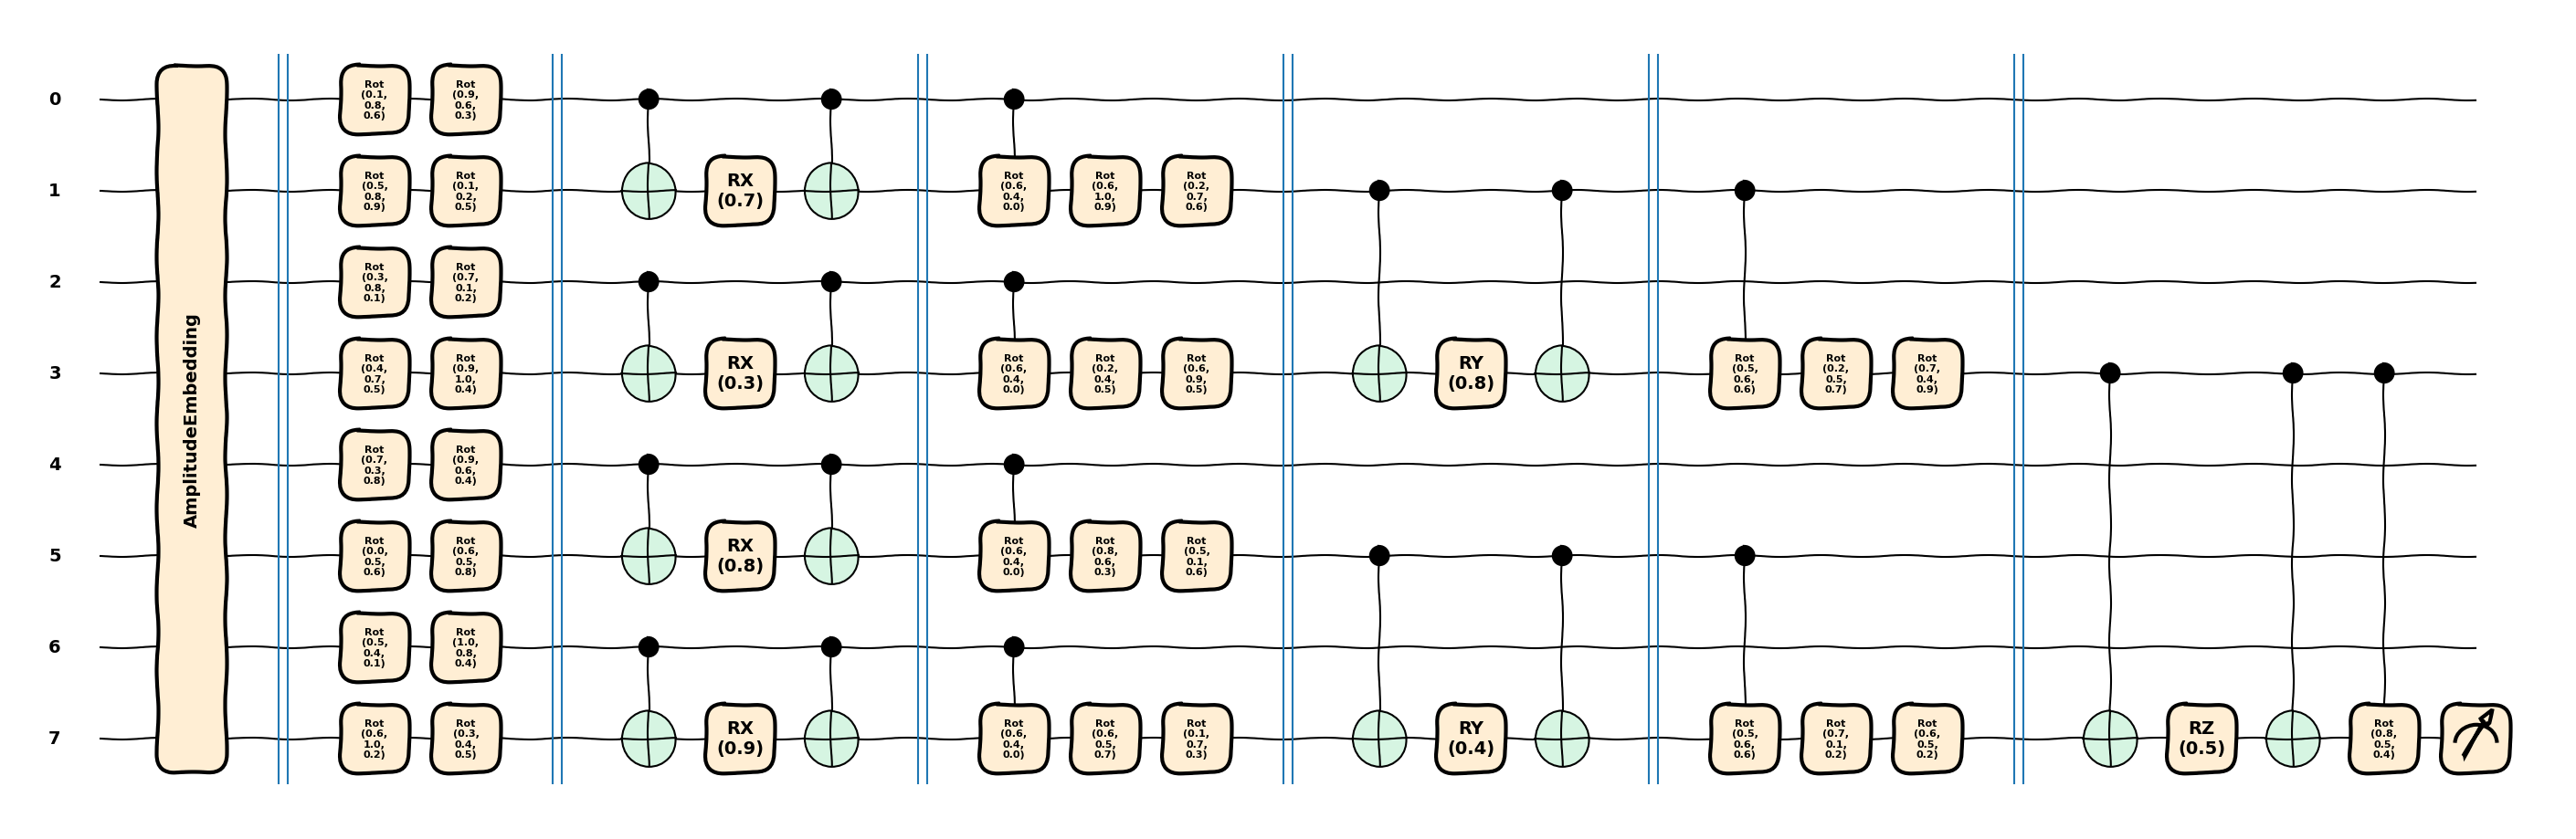

In [267]:
num_wires = 8  ## 256 features
device = qml.device("default.qubit", wires=num_wires)

@qml.qnode(device)
def conv_net_LONG_CREATED(weights, features):
    wires = list(range(num_wires))
    qml.AmplitudeEmbedding(features=features, wires=wires, pad_with=0.5)
    qml.Barrier(only_visual=True)
    first_layer(weights)
    qml.Barrier(only_visual=True)
    Ising(type='XX', control=0, target=1, weights=weights, weight_index=24)
    Ising(type='XX', control=2, target=3, weights=weights, weight_index=25)
    Ising(type='XX', control=4, target=5, weights=weights, weight_index=26)
    Ising(type='XX', control=6, target=7, weights=weights, weight_index=27)
    qml.Barrier(only_visual=True)
    first_pooling(0, weights, [28,29,30])
    first_pooling(2, weights, [28,29,30])
    first_pooling(4, weights, [28,29,30])
    first_pooling(6, weights, [28,29,30])
    second_layer(weights=weights, weight_index=51, qubits=[1,3,5,7])
    qml.Barrier(only_visual=True)
    Ising(type='YY', control=1, target=3, weights=weights, weight_index=40)
    Ising(type='YY', control=5, target=7, weights=weights, weight_index=41)
    qml.Barrier(only_visual=True)
    second_pooling(1, weights, [31, 32, 33])
    second_pooling(5, weights, [31, 32, 33])
    second_layer(weights=weights, weight_index=94, qubits=[3,7])
    qml.Barrier(only_visual=True)
    Ising(type='ZZ', control=3, target=7, weights=weights, weight_index=34)
    m_outcome = qml.measure(3)
    qml.cond(m_outcome, qml.Rot)(weights[35], weights[36], weights[37], 7)
    return qml.probs(wires=7)

    

qml.draw_mpl(conv_net_LONG_CREATED, style="sketch", decimals=1)(np.random.rand(114), np.random.rand(2 ** num_wires))

### LE QCNN hanno senso come i ragazzi di Pennylane avevano realizzato -> i parametri dei qubit sono in relazione fra loro, non a caso!

(<Figure size 2800x900 with 1 Axes>, <Axes: >)

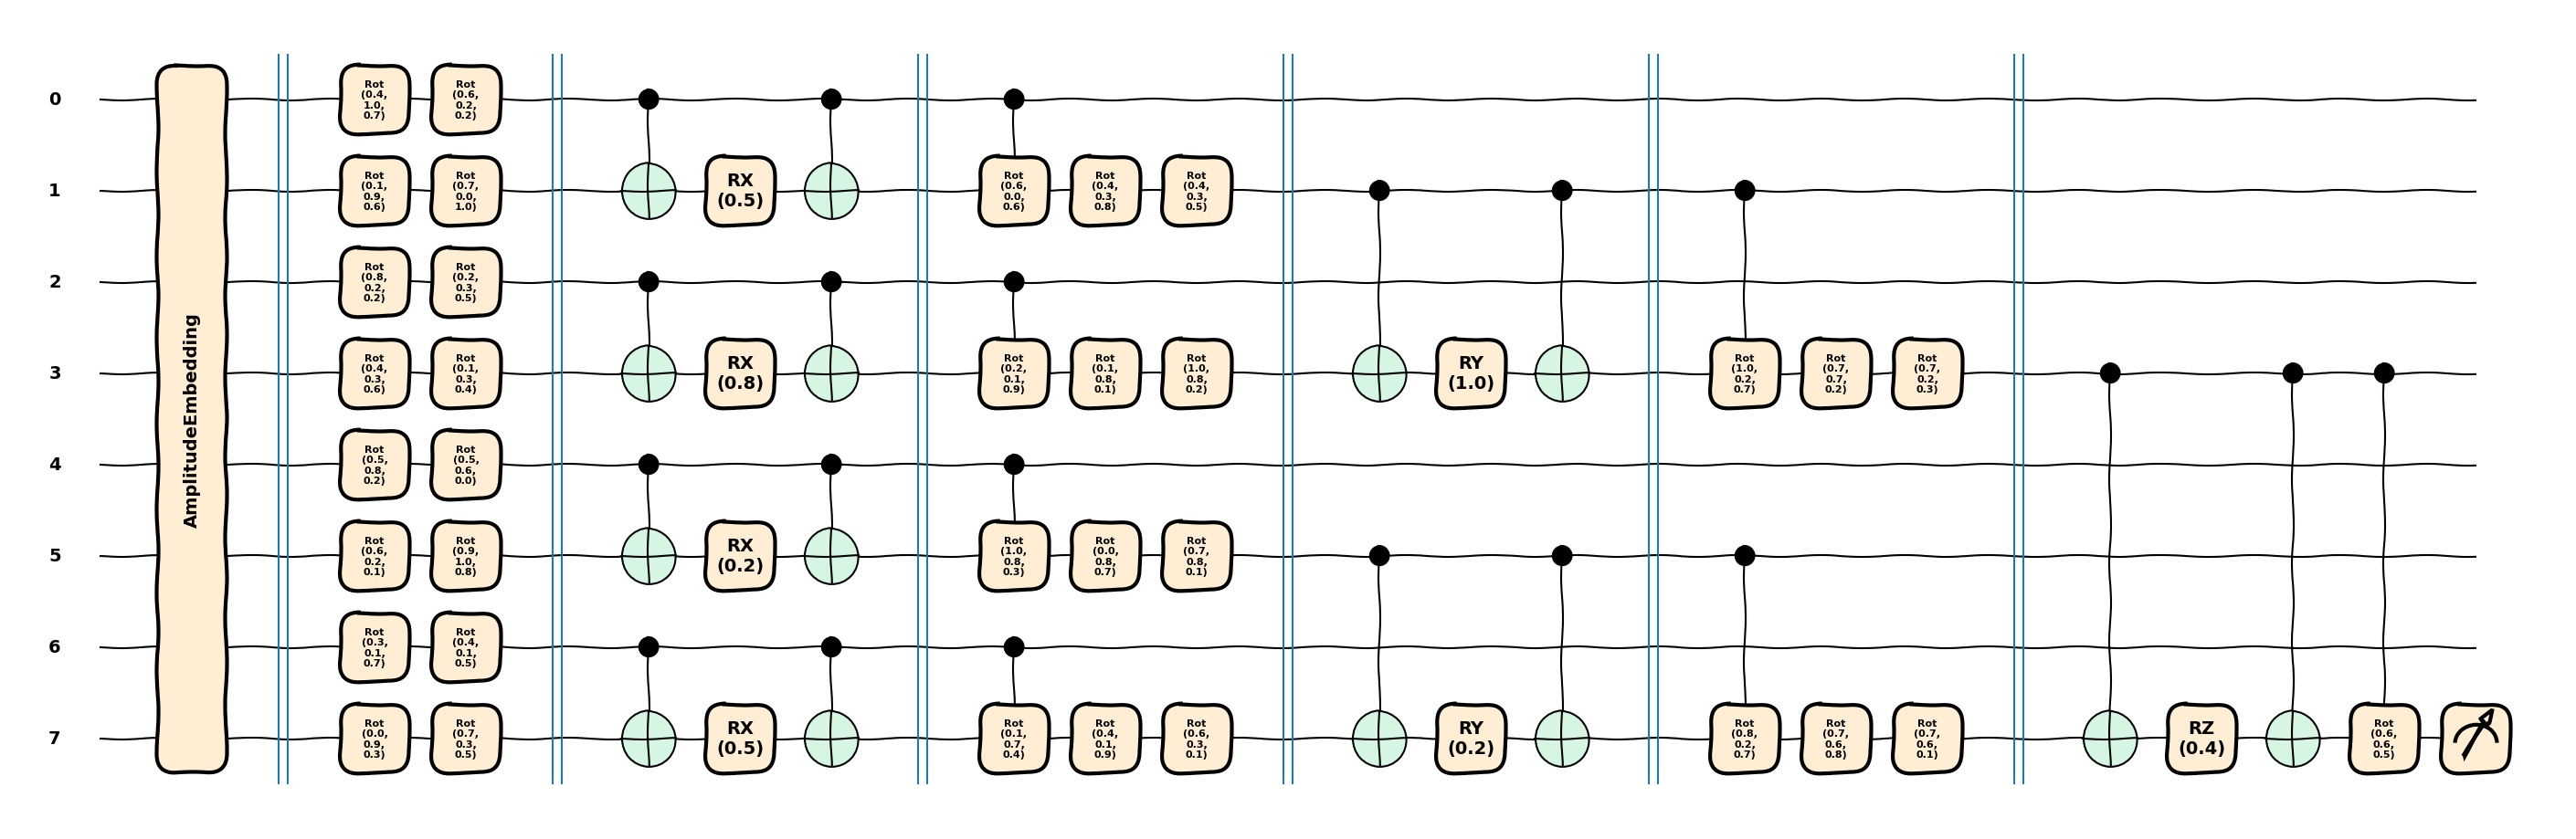

In [161]:
num_wires = 8  # 256 features
device = qml.device("default.qubit", wires=num_wires)

@qml.qnode(device)
def conv_net_LONG_CREATED(weights, features):
    # Unpack the weights tuple into separate tensors
    weights_first, weights_second = weights

    wires = list(range(num_wires))
    qml.AmplitudeEmbedding(features=features, wires=wires, pad_with=0.5)
    qml.Barrier(only_visual=True)

    # Use the first set of weights for the first part of the circuit
    first_layer(weights_first)
    qml.Barrier(only_visual=True)
    Ising(type='XX', control=0, target=1, weights=weights_first, weight_index=24)
    Ising(type='XX', control=2, target=3, weights=weights_first, weight_index=25)
    Ising(type='XX', control=4, target=5, weights=weights_first, weight_index=26)
    Ising(type='XX', control=6, target=7, weights=weights_first, weight_index=27)
    qml.Barrier(only_visual=True)
    first_pooling(0, weights_first, [28, 29, 30])
    first_pooling(2, weights_first, [31, 32, 33])
    first_pooling(4, weights_first, [34, 35, 36])
    first_pooling(6, weights_first, [37, 38, 39])
    second_layer(weights=weights_first, weight_index=60, qubits=[1, 3, 5, 7])
    qml.Barrier(only_visual=True)

    # Use the second set of weights for the second part of the circuit
    Ising(type='YY', control=1, target=3, weights=weights_second, weight_index=40)
    Ising(type='YY', control=5, target=7, weights=weights_second, weight_index=41)
    qml.Barrier(only_visual=True)
    second_pooling(1, weights_second, [40, 41, 42])
    second_pooling(5, weights_second, [43, 44, 45])
    second_layer(weights=weights_second, weight_index=97, qubits=[3, 7])
    qml.Barrier(only_visual=True)
    Ising(type='ZZ', control=3, target=7, weights=weights_second, weight_index=46)
    m_outcome = qml.measure(3)
    qml.cond(m_outcome, qml.Rot)(weights_second[47], weights_second[48], weights_second[49], 7)
    return qml.probs(wires=7)

# Generate random weights for the first and second parts of the circuit
np.random.seed(42)
weights_first = np.random.rand(114)
weights_second = np.random.rand(114)

# Pass the weights as a tuple to the circuit
weights_tuple = (weights_first, weights_second)

# Draw the modified circuit
qml.draw_mpl(conv_net_LONG_CREATED, style="sketch", decimals=1)(weights_tuple, np.random.rand(2 ** num_wires))


In [94]:
import tensorflow as tf
from keras.datasets import mnist

In [196]:
import tensorflow as tf
from keras.datasets import mnist

def downsample(x_array, size):
    newsize = (size, size)
    x_array = np.reshape(x_array, (x_array.shape[0], x_array.shape[1], 1))
    new_array = tf.image.resize(x_array, newsize)
    return new_array.numpy() 


def data(num_train_samples=None, num_test_samples=None, shuffle=False, resize=None): 
    (train_X, train_y), (test_X, test_y) = mnist.load_data()
    X_train_filtered = train_X[np.isin(train_y, [0, 1])]
    y_train_filtered = train_y[np.isin(train_y, [0, 1])]
    X_test_filtered = test_X[np.isin(test_y, [0, 1])]
    y_test_filtered = test_y[np.isin(test_y, [0, 1])]

    X_train_filtered = X_train_filtered.astype('float32') / 255
    X_test_filtered = X_test_filtered.astype('float32') / 255
    X_train_new = []
    X_test_new = []
    if resize is not None and resize <= 28:
        for train in X_train_filtered:
            X_train_new.append(downsample(train, resize))
        for test in X_test_filtered:
            X_test_new.append(downsample(test, resize))
    else: 
        raise Exception("The new size must be smaller than the actual Mnist size that is 28!")

    ### shuffle
    X_train_new = np.array(X_train_new)
    X_test_new = np.array(X_test_new)
    train_indices = np.arange(len(X_train_new))
    test_indices = np.arange(len(X_test_new))
    if shuffle == True:
        np.random.shuffle(train_indices)
        np.random.shuffle(test_indices)

    if num_train_samples is not None:
        X_train_ = np.array(X_train_new)[:num_train_samples]
        y_train_filtered = y_train_filtered[:num_train_samples]

    if num_test_samples is not None:
        X_test_ = np.array(X_test_new)[:num_test_samples]
        y_test_filtered = y_test_filtered[:num_test_samples]
        X_train_ = X_train_.reshape(X_train_.shape[0], X_train_.shape[1]*X_train_.shape[2])
        X_test_ = X_test_.reshape(X_test_.shape[0], X_test_.shape[1]*X_test_.shape[2])
    return (
        jnp.asarray(X_train_),
        jnp.asarray(y_train_filtered),
        jnp.asarray(X_test_),
        jnp.asarray(y_test_filtered),
    )

new_shape = 16
X_train, y_train, X_test, y_test = data(num_train_samples=400, num_test_samples=100, shuffle=True, resize=new_shape)

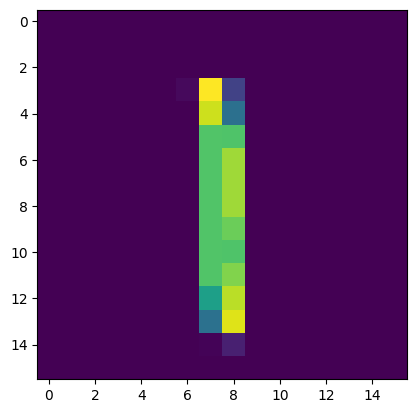

In [210]:
plt.imshow(X_train[4].reshape((16,16)))

In [97]:
from sklearn.metrics import accuracy_score

In [173]:
weights_first = np.random.rand(114)
weights_second = np.random.rand(114)

# Pass the weights as a tuple to the circuit
weights_tuple = (weights_first, weights_second)

# Call the circuit function with the weights tuple and the input features
print(conv_net_LONG_CREATED(weights_tuple, X_train[0]))

[0.47965035 0.5203499 ]


In [170]:
print(conv_net_LONG_CREATED(np.random.rand(114,114), X_train[0]))

ValueError: too many values to unpack (expected 2)

In [105]:
print(X_train[0])

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 6.5625004e-02 5.8590686e-01 5.8590686e-01 6.4338237e-02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 8.2720593e-02 7.5563729e-01 9.8425245e-01 9.4350493e-01 4.4963232e-01
 9.1911769e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 2.311

In [201]:
@jax.jit
def compute_out(weights, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    cost = lambda weights, feature, label: conv_net_LONG_CREATED(weights, feature)
    return jax.vmap(cost, in_axes=(None, 0, 0), out_axes=0)(
        weights, features, labels
    )

def catecross(weights,  features, labels):
    labels = jnp.array(labels)
    loss = 0
    out = jnp.array(compute_out(weights,  features, labels))
    for l, p in zip(labels, out):
        loss += l * (jnp.log(p[l])) + (1 - l) * jnp.log(1 - p[1 - l])
    return -1 * jnp.sum(loss)/len(labels)

def calculate_accuracy(weights, features, labels):
    labels = jnp.array(labels)
    predictions = jnp.array(compute_out(weights, features, labels))
    predicted_labels = jnp.argmax(predictions, axis=1)
    accuracy = jnp.mean(accuracy_score(labels, predicted_labels))
    return accuracy

In [164]:
value_and_grad = jax.jit(jax.value_and_grad(catecross, argnums=[0, 1]))

In [205]:
value_and_grad = jax.jit(jax.value_and_grad(catecross))

In [202]:
def optimizer_update(opt_state, params, features, labels):
    loss_value, grads = jax.value_and_grad(lambda theta: catecross(weights, features, labels))(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

In [176]:
def init_weights():
    """Initializes random weights for the QCNN model."""
    weights_first = np.random.rand(114)
    weights_second = np.random.rand(114)

# Pass the weights as a tuple to the circuit
    weights_tuple = (weights_first, weights_second)
    return weights_tuple

In [211]:
n_epochs = 400
seed = 448

key = jax.random.PRNGKey(seed)
initial_params = jax.random.normal(key, shape=(114,))
np.random.seed(7)
weights = jnp.copy((initial_params))

# learning rate decay
cosine_decay_scheduler = optax.cosine_decay_schedule(0.1, decay_steps=n_epochs, alpha=0.95)
optimizer = optax.adam(learning_rate=cosine_decay_scheduler)
opt_state = optimizer.init(initial_params)
train_cost_epochs, train_acc_epochs = [], []
for step in range(n_epochs):

        # Training step with (adam) optimizer
        train_cost, grad_circuit = value_and_grad(weights, X_train, y_train)
        updates, opt_state = optimizer.update(grad_circuit, opt_state)
        weights = optax.apply_updates(weights, updates)
        train_cost_epochs.append(train_cost)

        #compute accuracy on training data
        train_acc = calculate_accuracy(weights, X_train, y_train)
        train_acc_epochs.append(train_acc)
        print(f"Epoch {step}:", "---Train loss:", train_cost, "---Train acc.:", train_acc)
        # Save the optimal weights
        optimal_weights = weights

Epoch 0: ---Train loss: 0.7048182 ---Train acc.: 0.5525
Epoch 1: ---Train loss: 0.6577959 ---Train acc.: 0.74
Epoch 2: ---Train loss: 0.60787266 ---Train acc.: 0.7075
Epoch 3: ---Train loss: 0.5862933 ---Train acc.: 0.8325
Epoch 4: ---Train loss: 0.56801945 ---Train acc.: 0.915
Epoch 5: ---Train loss: 0.5478432 ---Train acc.: 0.9425
Epoch 6: ---Train loss: 0.5236202 ---Train acc.: 0.975
Epoch 7: ---Train loss: 0.5108377 ---Train acc.: 0.97
Epoch 8: ---Train loss: 0.5134583 ---Train acc.: 0.97
Epoch 9: ---Train loss: 0.5144495 ---Train acc.: 0.9825
Epoch 10: ---Train loss: 0.50899225 ---Train acc.: 0.9775
Epoch 11: ---Train loss: 0.50464725 ---Train acc.: 0.965
Epoch 12: ---Train loss: 0.50075954 ---Train acc.: 0.955
Epoch 13: ---Train loss: 0.49806118 ---Train acc.: 0.9525
Epoch 14: ---Train loss: 0.49704498 ---Train acc.: 0.9525
Epoch 15: ---Train loss: 0.49526078 ---Train acc.: 0.9575
Epoch 16: ---Train loss: 0.49202976 ---Train acc.: 0.965
Epoch 17: ---Train loss: 0.48961234 ---Trai

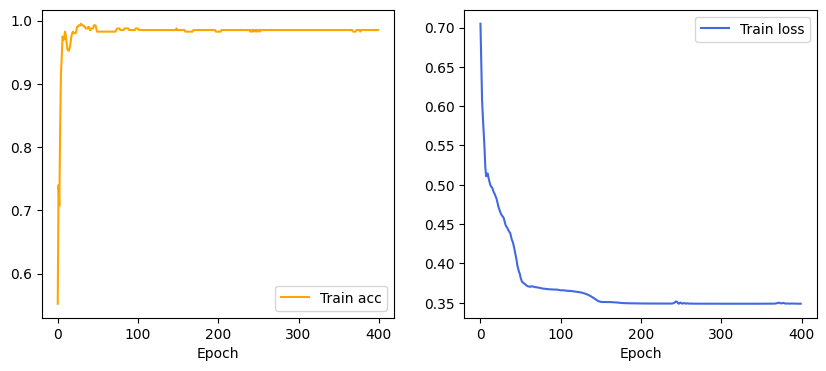

In [230]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(train_acc_epochs, label="Train acc", color="orange")
axs[0].set_xlabel("Epoch")
axs[1].plot(train_cost_epochs, label="Train loss", color="royalblue")
axs[1].set_xlabel("Epoch")
axs[0].legend(loc="best")
axs[1].legend(loc="upper right")

In [214]:
y_predicted = compute_out(optimal_weights, X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/autoray/autoray.py:981: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)


In [234]:
estimated_labels = jnp.array([jnp.argmax(label) for label in y_predicted])
print("Percentage of test images correctly predicted: ", accuracy_score(y_test, estimated_labels), "%")

Percentage of test images correctly predicted:  0.98 %


In [216]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

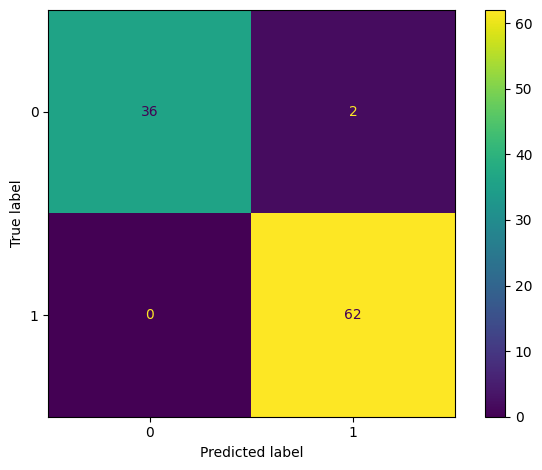

In [235]:
ConfusionMatrixDisplay(confusion_matrix(y_test, estimated_labels)).plot()
plt.tight_layout()

In [236]:
import medmnist as MED